In [1]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score

import seaborn as sns

from yellowbrick.cluster import SilhouetteVisualizer

import warnings


%load_ext autoreload
%autoreload 2

warnings.filterwarnings('ignore')


In [2]:
dataset_path = "..//datos//"
abnb_users_curated = "modified_train_users.csv"

In [3]:

users_df = pd.read_csv( dataset_path + abnb_users_curated)

In [4]:
# Print the number of records and the total number of movies
print('The dataset contains: ', len(users_df),' users.')

The dataset contains:  121070  users.


In [5]:
users_df.head()

,Unnamed: 0,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,...,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,total_seconds,average_seconds,total_sessions,number_of_devices,has_booked
0,1,820tgsjxq7,1306281600,1243100889,-9223372037,1,38.0,1,0,5,...,6,2,3,7,0,0.0,0.0,1,1,False
1,2,4ft3gnwmtx,1285632000,1244589167,1280707200,0,56.0,0,3,5,...,6,2,6,14,1,0.0,0.0,1,1,True
2,3,bjjt8pjhuk,1323043200,1256968889,1347062400,0,42.0,1,0,5,...,6,2,3,13,2,0.0,0.0,1,1,True
3,4,87mebub9p4,1284422400,1260252665,1266451200,2,41.0,0,0,5,...,6,2,3,7,1,0.0,0.0,1,1,True
4,6,lsw9q7uk0j,1262390400,1262395558,1262649600,0,46.0,0,0,5,...,6,2,3,30,1,0.0,0.0,1,1,True


In [6]:
users_has_booked_df = users_df[ users_df['has_booked'] == True]
users_to_cluster_df = users_has_booked_df[ ['age']]

print( "Number of records: ", len(users_to_cluster_df))
users_to_cluster_df.head()

Number of records:  66836


,age
1,56.0
2,42.0
3,41.0
4,46.0
5,47.0


In [7]:
# Let's turn our dataset into a list

users_to_cluster = users_to_cluster_df.values

In [8]:
# Defining the scatterplot drawing function
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)    
    
    #plt.xlim(0, 5)
   # plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)
    

In [9]:
# Defining the cluster plotting function
def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    ax.set_xlabel('gender')
    ax.set_ylabel('region')
    
    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['gender'], clustered['age'], c=clustered['group'], s=20, cmap=cmap)
    


In [10]:
def add_cluster_to_dataset( original_df, predictions):
    return  pd.concat([original_df.reset_index(), pd.DataFrame({'group':predictions})], axis=1)

In [11]:
def cluster_show_by_age_region( clustered ):

#    fig = plt.figure(figsize=(8,8))
#    ax = fig.add_subplot(111)
#    ax.set_xlabel('age')
#    ax.set_ylabel('region')

#    plt.scatter(clustered['age'], clustered['region_destination'], label='group', c=clustered['group'], s=20)
#    plt.scatter(clustered['age'], clustered['region_destination'], 
#                label=, c=clustered['group'], s=20,
#               marker='o')
 
#    plt.legend(loc=2)
#    plt.show()   

    sns.set(style="white")
    sns.relplot(x="age", y="region_destination", hue="group",
            sizes=(40, 400), alpha=.5,
            height=6, data=clustered)

In [12]:
def cluster_show_by_age_gender( clustered ):

#    fig = plt.figure(figsize=(8,8))
#    ax = fig.add_subplot(111)
#    ax.set_xlabel('age')
#    ax.set_ylabel('region')

#    plt.scatter(clustered['age'], clustered['region_destination'], label='group', c=clustered['group'], s=20)
#    plt.scatter(clustered['age'], clustered['region_destination'], 
#                label=, c=clustered['group'], s=20,
#               marker='o')
 
#    plt.legend(loc=2)
#    plt.show()   
    colores=['red','green','blue','cyan','yellow']
    sns.set(style="white")
    sns.relplot(x="gender", y="age", hue="group",
            sizes=(40, 400), alpha=.5,
            height=6, data=clustered)

In [13]:
def cluster_show_by( clustered, x_label, y_label):

#    fig = plt.figure(figsize=(8,8))
#    ax = fig.add_subplot(111)
#    ax.set_xlabel('age')
#    ax.set_ylabel('region')

#    plt.scatter(clustered['age'], clustered['region_destination'], label='group', c=clustered['group'], s=20)
#    plt.scatter(clustered['age'], clustered['region_destination'], 
#                label=, c=clustered['group'], s=20,
#               marker='o')
 
#    plt.legend(loc=2)
#    plt.show()   
    colores=['red','green','blue','cyan','yellow']
    sns.set(style="white")
    sns.relplot(x=x_label, y=y_label, hue="group",
            sizes=(40, 400), alpha=.5,
            height=6, data=clustered)

# Clustering

Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a __measure of how close each point in one cluster is to points in the neighboring clusters__ and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].

Silhouette coefficients (as these values are referred to as):  
* near +1 indicate that the sample is far away from the neighboring clusters. 
* A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and   
* negative values indicate that those samples might have been assigned to the wrong cluster

## Ejecutamos K-Means para valores de k entre 2 y 5


k =  2
Inertia:  2656040.0094788037
Centers:  [[30.93673055]
 [52.50108905]]


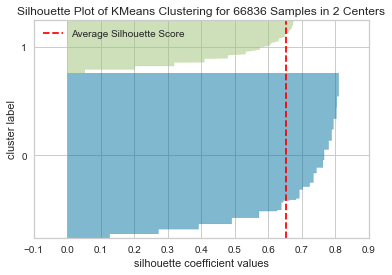


k =  3
Inertia:  1370105.7343367427
Centers:  [[58.89214211]
 [28.56363685]
 [40.2121154 ]]


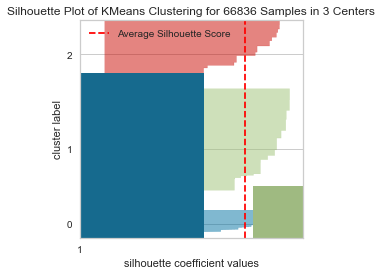


k =  4
Inertia:  834711.6256292487
Centers:  [[26.47539021]
 [46.30098656]
 [62.57892882]
 [34.68150413]]


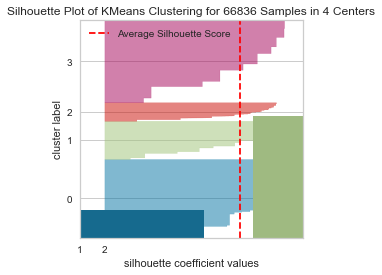


k =  5
Inertia:  580661.8151119204
Centers:  [[32.2186485 ]
 [52.26318651]
 [66.35278592]
 [25.22350472]
 [40.77673738]]


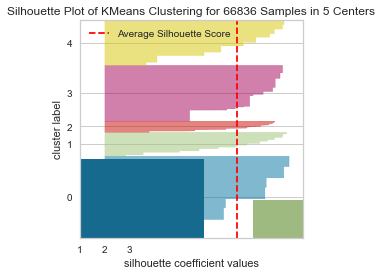

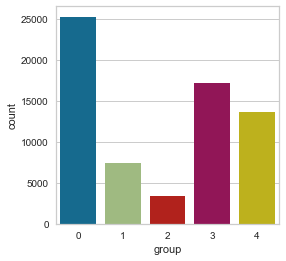

In [15]:
# Clusters to generate

k_sets = [2,3,4,5]

for k in k_sets:
    
    print("\nk = ", k)
    
    clusterer = KMeans( k, random_state=7 )
    
    predictions = clusterer.fit_predict( users_to_cluster )
 
    print("Inertia: ", clusterer.inertia_ )
    print("Centers: ", clusterer.cluster_centers_)

    visualizer = SilhouetteVisualizer(clusterer, colors='yellowbrick')

    visualizer.fit(users_to_cluster)        # Fit the data to the visualizer
    visualizer.show()        # Finalize and render the figure

#    silhouette_avg = silhouette_score(users_to_cluster, predictions)
#    print("Para n_clusters =", k,
#          "El silhouette_score promedio es :", silhouette_avg)
    #print( predictions.score(users_to_cluster))
    

    
    plt.figure(figsize=(4,4))
    sns.countplot(data=pd.DataFrame({'group':predictions}), x='group')

#   clustered = add_cluster_to_dataset(users_to_cluster_df, predictions)

    #cluster_show_by( clustered, 'has_booked', 'age') 

In [ ]:
sns.pairplot(clustered.dropna(), hue='group',size=5,vars=["age"],kind='scatter')

In [ ]:
nc = range(1, 4)
kmeans = [KMeans(n_clusters=i) for i in nc]

In [ ]:
score = [kmeans[i].fit(users_to_cluster).score(users_to_cluster) for i in range(len(kmeans))]
score

In [ ]:
plt.plot(nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()